**<center>===========================================================================================================</center>**
**<center>All Necessary Imports</center>**
**<center>===========================================================================================================</center>**

In [7]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psutil
from collections import Counter
from joblib import Parallel, delayed, parallel_backend
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

**<center>===========================================================================================================</center>**
**<center>Check Available Resources & Load the Data</center>**
**<center>===========================================================================================================</center>**

In [8]:
num_cores = psutil.cpu_count(logical=True)
cpu_percent_per_core = psutil.cpu_percent(percpu=True)

print(f"Total number of CPU cores: {num_cores}")
print(f"CPU utilization per core: {cpu_percent_per_core}")

threshold = 30.0
free_cores = sum(1 for percent in cpu_percent_per_core if percent < threshold)
print(f"Number of free CPU cores: {free_cores}")

data = pd.read_csv('data/processed/one_hot_encoded_data.csv')

with open('data/processed/feature_categories.json') as f:
    feature_categories = json.load(f)

continuous_features = feature_categories['continuous_features']
categorical_features = feature_categories['categorical_features']
target = feature_categories['target']
features = data.drop(columns=['readmitted'])
target = data['readmitted']

# Sanitize feature names
features.columns = [col.replace('[', '').replace(']', '').replace('<', '').replace('>', '').replace(' ', '_') for col in features.columns]

label_encoder = LabelEncoder() # Encode the target variable
target = label_encoder.fit_transform(target)

Total number of CPU cores: 32
CPU utilization per core: [1.5, 1.6, 2.6, 0.2, 2.4, 0.2, 2.2, 1.6, 41.7, 57.1, 44.8, 47.1, 2.5, 0.2, 2.7, 0.4, 0.9, 0.7, 0.6, 0.5, 0.4, 0.4, 0.5, 0.3, 0.4, 0.3, 0.3, 0.4, 0.3, 0.3, 0.4, 0.5]
Number of free CPU cores: 28


**<center>===========================================================================================================</center>**
**<center>Class Imbalance Check</center>**
**<center>===========================================================================================================</center>**

Class counts: 
readmitted
NO     39280
YES    27312
Name: count, dtype: int64
Proportion of 'NO': 58.99%
Proportion of 'YES': 41.01%


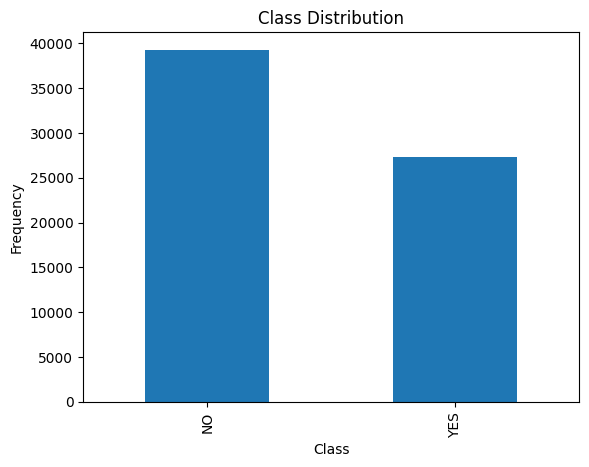

In [9]:
class_counts = data['readmitted'].value_counts()
total = class_counts.sum()
no_proportion = (class_counts['NO'] / total) * 100
yes_proportion = class_counts['YES'] / total * 100

print(f"Class counts: \n{class_counts}")
print(f"Proportion of 'NO': {no_proportion:.2f}%")
print(f"Proportion of 'YES': {yes_proportion:.2f}%")

class_counts.plot(kind='bar')

plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution')
plt.show()

**<center>===========================================================================================================</center>**
**<center>ANOVA F-Test</center>**
**<center>===========================================================================================================</center>**

In [10]:
select_k_best = SelectKBest(f_classif, k='all')
select_k_best.fit(features[continuous_features], target)
p_values = select_k_best.pvalues_

p_threshold = 0.05 # p-value threshold for significance
selected_indices = [i for i, p_value in enumerate(p_values) if p_value < p_threshold]
selected_features_names = features[continuous_features].columns[selected_indices]

dropped_features_names = [feature for i, feature in enumerate(features[continuous_features].columns) if i not in selected_indices]
features = features.drop(columns=dropped_features_names)
dropped_count = len(dropped_features_names)
selected_count = len(selected_features_names)

print(f"{dropped_count} features were dropped.")
print(f"{selected_count} features were selected based on p-value threshold.")

0 features were dropped.
6 features were selected based on p-value threshold.


**<center>===========================================================================================================</center>**
**<center>PCA Analysis</center>**
**<center>===========================================================================================================</center>**

Original number of components: 6
Number of components retained: 6
Shape of the transformed DataFrame: (66592, 2255)
Explained Variance Ratio of each Principal Component:
['PC1: 0.3121', 'PC2: 0.1824', 'PC3: 0.1629', 'PC4: 0.1403', 'PC5: 0.1120', 'PC6: 0.0902']

Cumulative Explained Variance:
['PC1: 0.3121', 'PC2: 0.4946', 'PC3: 0.6575', 'PC4: 0.7978', 'PC5: 0.9098', 'PC6: 1.0000']


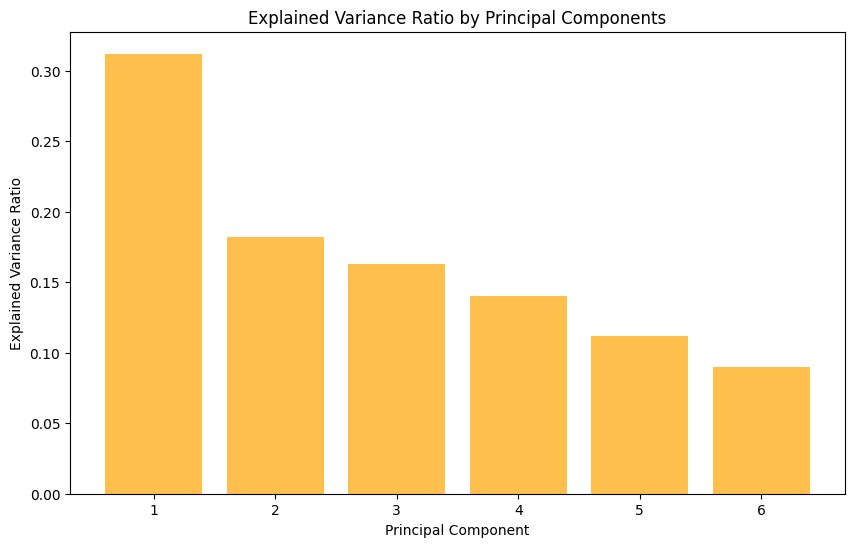

In [11]:
pca = PCA(n_components=0.95)
pca_transformed_array = pca.fit_transform(features[continuous_features])
pca_transformed_df = pd.DataFrame(pca_transformed_array, columns=[f"PC{i+1}" for i in range(pca_transformed_array.shape[1])])

original_components = features[continuous_features].shape[1]
retained_components = pca_transformed_df.shape[1]

print(f"Original number of components: {original_components}")
print(f"Number of components retained: {retained_components}")
print(f"Shape of the transformed DataFrame: {features.shape}")

explained_variance_ratio = pca.explained_variance_ratio_
explained_variance_ratio_list = [f"PC{i+1}: {ratio:.4f}" for i, ratio in enumerate(explained_variance_ratio)]
cumulative_explained_variance = explained_variance_ratio.cumsum()
cumulative_explained_variance_list = [f"PC{i+1}: {cumulative_ratio:.4f}" for i, cumulative_ratio in enumerate(cumulative_explained_variance)]

print("Explained Variance Ratio of each Principal Component:")
print(f"{explained_variance_ratio_list}")
print("\nCumulative Explained Variance:")
print(f"{cumulative_explained_variance_list}")

plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7, align='center', color='#FFA500')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Principal Components')
plt.show()

**<center>===========================================================================================================</center>**
**<center>RFECV Feature Selection</center>**
**<center>===========================================================================================================</center>**

In [ ]:
def run_rfecv(seed, iteration, total_iterations, features, target):
    np.random.seed(seed)

    print(f"Iteration {iteration + 1}/{total_iterations} started with seed {seed}")
    
    rfecv = RFECV(estimator=RandomForestClassifier(), step=1, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=seed), scoring='accuracy', verbose=0)
    features_copy = features.copy()
    target_copy = target.copy()
    
    rfecv.fit(features_copy, target_copy)
    optimal_features = list(features.columns[np.where(rfecv.ranking_ == 1)[0]])
    
    print(f"Iteration {iteration + 1}/{total_iterations} completed.")
    return optimal_features

num_iterations = 10
seeds = np.random.randint(0, 10000, size=num_iterations)

with parallel_backend('loky', inner_max_num_threads=1):
    selected_features_list = Parallel(n_jobs=free_cores)(
        delayed(run_rfecv)(seed, i, num_iterations, features, target) for i, seed in enumerate(seeds)
    )

Iteration 3/10 started with seed 7982
Iteration 1/10 started with seed 3777
Iteration 2/10 started with seed 2176
Iteration 7/10 started with seed 4665
Iteration 5/10 started with seed 2740
Iteration 8/10 started with seed 9913
Iteration 10/10 started with seed 2806
Iteration 9/10 started with seed 2345
Iteration 4/10 started with seed 7178
Iteration 6/10 started with seed 2519


In [ ]:
# Analyze Feature Selection Stability
feature_counter = Counter([item for sublist in selected_features_list for item in sublist])
features_frequency_df = pd.DataFrame.from_dict(feature_counter, orient='index', columns=['Frequency']).sort_values(by='Frequency', ascending=False)

print(f"Feature selection stability: {feature_counter}")
print(f"Features frequency DataFrame:\n{features_frequency_df}")

threshold = num_iterations * 0.60
stable_features = features_frequency_df[features_frequency_df['Frequency'] >= threshold].index.tolist()

print(f"Stable features: {stable_features}")
print(f"Total features pre-RFE = {features.shape[1]}")
print(f"Total features post-RFE = {features[stable_features].shape[1]}")

**<center>===========================================================================================================</center>**
**<center>Saving the Final Selected Features for Next Stage</center>**
**<center>===========================================================================================================</center>**

In [ ]:
selected_features_df = features[stable_features]
selected_features_df.loc[:, 'target'] = target
selected_features_df.to_csv('data/processed/selected_features.csv', index=False)